# **2CS703- Minor Project**

# **Stock Market Prediction using Deep Learning Techniques**

Prepared by:
## 18BCE028 - Nachiketa Bhoraniya
## 18BCE240 - Kunj Thaker

Guided by:
## Prof. Ajaykumar Patel


### **We have used LSTM(Long Short Term Memory), CNN(Convolutional Neural Network), GRU(Gated Recurrent Unit) and RNN(Recurrent Neural Network) models to predict the stock price of AMZN dataset**

Dataset is yahoo-financials AMZN datase.

Installing Libraries which are required

In [ ]:
!pip install yfinance
!pip install yahoofinancials
!pip install tensorflow
!pip install tensorflow==1.2.0 --ignore-installed

     |████████████████████████████████| 6.3 MB 8.1 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15190 sha256=59c63669030deed9a300ee9e782325e293612a056ac3331991a263470d8108a0
  Stored in directory: /root/.cache/pip/wheels/4b/63/46/e7110bfee88685fe69e338d1b14d1748921862aa57b6705b60
Successfully built yahoofinancials
ERROR: Could not find a version that satisfies the requirement tensorflow==1.2.0 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Importing Packages for models

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
#from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from keras.models import Sequential, Model
from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout, Input
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from keras.layers import Dense,GlobalAveragePooling2D
from keras.optimizers import gradient_descent_v2

Importing Amazon dataset from yahoo financials and visulize it

            Adj Close    Open    High     Low   Close   Volume
Date                                                          
2013-01-02     257.31  256.08  258.10  253.26  257.31  3271000
2013-01-03     258.48  257.27  260.88  256.37  258.48  2750900
2013-01-04     259.15  257.58  259.80  256.65  259.15  1874200
2013-01-07     268.46  262.97  269.73  262.67  268.46  4910000
2013-01-08     266.38  267.07  268.98  263.57  266.38  3010700
2013-01-09     266.35  268.17  269.50  265.40  266.35  2265600
2013-01-10     265.34  268.54  268.74  262.30  265.34  2863400
2013-01-11     267.94  265.10  268.43  264.11  267.94  2413300
2013-01-14     272.73  268.00  274.26  267.54  272.73  4275000
2013-01-15     271.90  270.68  272.73  269.30  271.90  2326900
There are 1510 observations in the training data
There are 251 observations in the test data


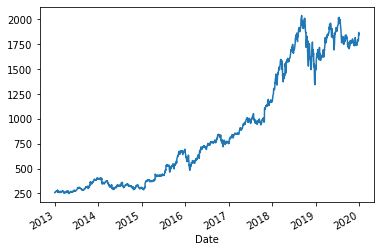

In [ ]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
AMZN = yf.download('AMZN', 
                      start='2013-01-01', 
                      end='2019-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN') for all 
all_data = AMZN[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
print(all_data.head(10))
print("There are "+ str(all_data[:'2018'].shape[0]) + " observations in the training data")
print("There are "+ str(all_data['2019':].shape[0]) + " observations in the test data")
all_data['Adj Close'].plot()
# There are 1,510 and 251 observations in the training and test data respectively.

Here time_steps=10 means previous 10 day stock price are taken into considerations for_periods=5 means next 5 days

In [ ]:
def ts_train_test(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
    time_steps: # of the input time steps
    for_periods: # of the output time steps
    '''
    # create training and test set
    ts_train = all_data[:'2018'].iloc[:,0:1].values
    ts_test  = all_data['2019':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Preparing to create X_test
    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)

    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test

X_train, y_train, X_test = ts_train_test(all_data,10,5)
X_train.shape[0],X_train.shape[1]

(1499, 10)

In [ ]:
# Convert the 3-D shape of X_train to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see,y_train_see],axis=1)

# Convert the 3-D shape of X_test to a data frame so we can see: 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 1499 samples in the training data
There are 246 samples in the test data


In [ ]:
print(X_train_see)

            0        1        2        3  ...        6        7        8        9
0      257.31   258.48   259.15   268.46  ...   265.34   267.94   272.73   271.90
1      258.48   259.15   268.46   266.38  ...   267.94   272.73   271.90   268.93
2      259.15   268.46   266.38   266.35  ...   272.73   271.90   268.93   270.48
3      268.46   266.38   266.35   265.34  ...   271.90   268.93   270.48   272.12
4      266.38   266.35   265.34   267.94  ...   268.93   270.48   272.12   270.19
...       ...      ...      ...      ...  ...      ...      ...      ...      ...
1494  1629.13  1641.03  1643.24  1663.54  ...  1520.91  1551.48  1495.08  1460.83
1495  1641.03  1643.24  1663.54  1658.38  ...  1551.48  1495.08  1460.83  1377.45
1496  1643.24  1663.54  1658.38  1591.91  ...  1495.08  1460.83  1377.45  1343.96
1497  1663.54  1658.38  1591.91  1520.91  ...  1460.83  1377.45  1343.96  1470.90
1498  1658.38  1591.91  1520.91  1551.48  ...  1377.45  1343.96  1470.90  1461.64

[1499 rows x 10

Function for plotting curve and calculating MSE(Mean Squared Error) and MAE(Mean Absolute Error)

In [ ]:
def actual_pred_plot(preds):
    '''
    Plot the actual vs. prediction
    '''
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    print("Mean Squared Error:",metrics.mean_squared_error(y_true = np.array(actual_pred['Adj. Close']), y_pred = np.array(actual_pred['prediction'])))
    print("Mean Absolute Error:",metrics.mean_absolute_error(y_true = np.array(actual_pred['Adj. Close']), y_pred = np.array(actual_pred['prediction'])))
    
    
    return (m.result().numpy(), actual_pred.plot() )

Normalize the values using MinMaxScalar

In [ ]:
from sklearn import metrics
def ts_train_test_normalize(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = all_data[:'2018'].iloc[:,0:1].values
    ts_test  = all_data['2019':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))

    return X_train, y_train , X_test, sc

In [ ]:
X_train, y_train, X_test, sc = ts_train_test_normalize(all_data,10,2)

### **1)Long Short Term Memory(LSTM) Model**

**Why to use tanh activation function?**

tanh function is symmetric about the origin, where the inputs would be normalized and they are more likely to produce outputs (which are inputs to next layer)and also, they are on an average close to zero. This is the main reasons why tanh is preferred and performs better than sigmoid (logistic).

In [ ]:
def LSTM_model_regularization(X_train, y_train, X_test, sc):
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))

    # dropout is done to reduce overfitting
    my_LSTM_model.add(Dropout(0.3))
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))

    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))

    # dense is a fully connected layer and units defines the output shape
    my_LSTM_model.add(Dense(units=2))
    
    # Compiling
    my_LSTM_model.compile(optimizer=gradient_descent_v2.SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=100,batch_size=150, verbose=2)

    #predicting stock prices
    LSTM_prediction = my_LSTM_model.predict(X_test)

    #inverse transformation to transfer prediction of LSTM network to its original range
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    my_LSTM_model.summary()
    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model_regularization(X_train, y_train, X_test, sc)

Epoch 1/100
10/10 - 5s - loss: 0.0957 - 5s/epoch - 526ms/step
Epoch 2/100
10/10 - 0s - loss: 0.0706 - 345ms/epoch - 34ms/step
Epoch 3/100
10/10 - 0s - loss: 0.0592 - 327ms/epoch - 33ms/step
Epoch 4/100
10/10 - 0s - loss: 0.0545 - 325ms/epoch - 32ms/step
Epoch 5/100
10/10 - 0s - loss: 0.0481 - 337ms/epoch - 34ms/step
Epoch 6/100
10/10 - 0s - loss: 0.0421 - 330ms/epoch - 33ms/step
Epoch 7/100
10/10 - 0s - loss: 0.0351 - 331ms/epoch - 33ms/step
Epoch 8/100
10/10 - 0s - loss: 0.0277 - 331ms/epoch - 33ms/step
Epoch 9/100
10/10 - 0s - loss: 0.0201 - 319ms/epoch - 32ms/step
Epoch 10/100
10/10 - 0s - loss: 0.0124 - 320ms/epoch - 32ms/step
Epoch 11/100
10/10 - 0s - loss: 0.0067 - 332ms/epoch - 33ms/step
Epoch 12/100
10/10 - 0s - loss: 0.0030 - 327ms/epoch - 33ms/step
Epoch 13/100
10/10 - 0s - loss: 0.0012 - 321ms/epoch - 32ms/step
Epoch 14/100
10/10 - 0s - loss: 8.3497e-04 - 332ms/epoch - 33ms/step
Epoch 15/100
10/10 - 0s - loss: 7.5657e-04 - 322ms/epoch - 32ms/step
Epoch 16/100
10/10 - 0s - lo

In [ ]:
LSTM_prediction[1:10]

array([[1484.3597, 1486.3893],
       [1474.0801, 1475.8239],
       [1474.0741, 1475.6317],
       [1482.339 , 1483.7836],
       [1505.6786, 1507.2502],
       [1536.798 , 1538.6494],
       [1554.0645, 1555.9524],
       [1574.7078, 1576.7128],
       [1594.2997, 1596.4513]], dtype=float32)

Mean Squared Error: 3418.400874664436
Mean Absolute Error: 46.30838027892821


(3418.4011, <matplotlib.axes._subplots.AxesSubplot at 0x7f54eb1fa450>)

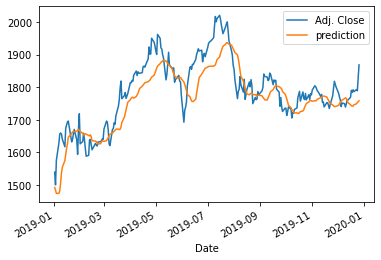

In [ ]:
actual_pred_plot(LSTM_prediction)

In [ ]:
print(X_train.shape)

(1499, 10, 1)


In [ ]:
print(X_train)

[[[0.005069  ]
  [0.00572217]
  [0.0060962 ]
  [0.0112936 ]
  [0.01013242]]

 [[0.00572217]
  [0.0060962 ]
  [0.0112936 ]
  [0.01013242]
  [0.01011567]]

 [[0.0060962 ]
  [0.0112936 ]
  [0.01013242]
  [0.01011567]
  [0.00955183]]

 ...

 [[0.72755236]
  [0.6960665 ]
  [0.67694609]
  [0.63039837]
  [0.61170225]]

 [[0.6960665 ]
  [0.67694609]
  [0.63039837]
  [0.61170225]
  [0.68256777]]

 [[0.67694609]
  [0.63039837]
  [0.61170225]
  [0.68256777]
  [0.67739829]]]


## **2)Convolutional Neural Network(CNN) Model**

CNN with LSTM

In [ ]:
model = Sequential()

#add model layers
'''
One reason you should consider when using ReLUs is, that they can produce dead neurons.
That means that under certain circumstances your network can produce regions in which the
network won't update, and the output is always 0.

As a consequence, the usage of ReLU helps to prevent the exponential growth in the
computation required to operate the neural network. If the CNN scales in size, the
computational cost of adding extra ReLUs increases linearly.
'''
model.add(Conv1D(128, kernel_size=1, activation='relu', input_shape=(X_train.shape[1],1)))

'''
Max Pooling is a convolution process where the Kernel extracts the maximum value of the area
it convolves. Max Pooling simply says to the Convolutional Neural Network that we will carry
forward only that information, if that is the largest information available amplitude wise.
'''
model.add(MaxPooling1D(2))

model.add(Conv1D(256, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(2))

model.add(Conv1D(512, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(2))

#model.add(Flatten())
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200,return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='RMSprop', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=2)
model.summary()

Epoch 1/100
10/10 - 9s - loss: 0.0597 - 9s/epoch - 907ms/step
Epoch 2/100
10/10 - 1s - loss: 0.0034 - 1s/epoch - 124ms/step
Epoch 3/100
10/10 - 1s - loss: 0.0044 - 1s/epoch - 123ms/step
Epoch 4/100
10/10 - 1s - loss: 0.0081 - 1s/epoch - 122ms/step
Epoch 5/100
10/10 - 1s - loss: 0.0084 - 1s/epoch - 122ms/step
Epoch 6/100
10/10 - 1s - loss: 0.0062 - 1s/epoch - 120ms/step
Epoch 7/100
10/10 - 1s - loss: 0.0073 - 1s/epoch - 124ms/step
Epoch 8/100
10/10 - 1s - loss: 0.0063 - 1s/epoch - 119ms/step
Epoch 9/100
10/10 - 1s - loss: 0.0048 - 1s/epoch - 121ms/step
Epoch 10/100
10/10 - 1s - loss: 0.0057 - 1s/epoch - 120ms/step
Epoch 11/100
10/10 - 1s - loss: 0.0057 - 1s/epoch - 122ms/step
Epoch 12/100
10/10 - 1s - loss: 0.0048 - 1s/epoch - 119ms/step
Epoch 13/100
10/10 - 1s - loss: 0.0044 - 1s/epoch - 119ms/step
Epoch 14/100
10/10 - 1s - loss: 0.0047 - 1s/epoch - 119ms/step
Epoch 15/100
10/10 - 1s - loss: 0.0057 - 1s/epoch - 122ms/step
Epoch 16/100
10/10 - 1s - loss: 0.0039 - 1s/epoch - 119ms/step
E

Mean Squared Error: 3440.4698497309446
Mean Absolute Error: 47.0482219699109


(3440.4705, <matplotlib.axes._subplots.AxesSubplot at 0x7f54f9f8b150>)

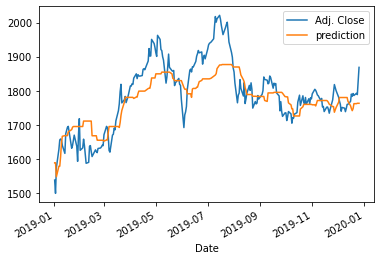

In [ ]:
CNN_prediction = model.predict(X_test)
CNN_prediction = sc.inverse_transform(CNN_prediction)

CNN_prediction[1:10]
actual_pred_plot(CNN_prediction)

# **3)Gated Recurrent Unit (GRU Model)**

In [ ]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model
    
    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation

    my_GRU_model.add(GRU(units=60, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(Dropout(0.3))

    my_GRU_model.add(GRU(units=60, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(GRU(units=60, activation='tanh'))
    my_GRU_model.add(Dense(units=2))

    # Compiling the RNN
    my_GRU_model.compile(optimizer=gradient_descent_v2.SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_GRU_model.fit(X_train,y_train,epochs=100,batch_size=150, verbose=2)

    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    my_GRU_model.summary()
    return my_GRU_model, GRU_prediction

my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)

Epoch 1/100
10/10 - 5s - loss: 0.0805 - 5s/epoch - 538ms/step
Epoch 2/100
10/10 - 0s - loss: 0.0523 - 325ms/epoch - 32ms/step
Epoch 3/100
10/10 - 0s - loss: 0.0315 - 325ms/epoch - 32ms/step
Epoch 4/100
10/10 - 0s - loss: 0.0155 - 341ms/epoch - 34ms/step
Epoch 5/100
10/10 - 0s - loss: 0.0055 - 321ms/epoch - 32ms/step
Epoch 6/100
10/10 - 0s - loss: 0.0010 - 328ms/epoch - 33ms/step
Epoch 7/100
10/10 - 0s - loss: 3.6786e-04 - 343ms/epoch - 34ms/step
Epoch 8/100
10/10 - 0s - loss: 4.6563e-04 - 329ms/epoch - 33ms/step
Epoch 9/100
10/10 - 0s - loss: 3.9113e-04 - 324ms/epoch - 32ms/step
Epoch 10/100
10/10 - 0s - loss: 3.2565e-04 - 330ms/epoch - 33ms/step
Epoch 11/100
10/10 - 0s - loss: 3.1819e-04 - 321ms/epoch - 32ms/step
Epoch 12/100
10/10 - 0s - loss: 3.1673e-04 - 327ms/epoch - 33ms/step
Epoch 13/100
10/10 - 0s - loss: 3.1648e-04 - 329ms/epoch - 33ms/step
Epoch 14/100
10/10 - 0s - loss: 3.1475e-04 - 326ms/epoch - 33ms/step
Epoch 15/100
10/10 - 0s - loss: 3.1551e-04 - 324ms/epoch - 32ms/step


Mean Squared Error: 1989.0982645870422
Mean Absolute Error: 34.67462235661395


(1989.0985, <matplotlib.axes._subplots.AxesSubplot at 0x7f54ee526990>)

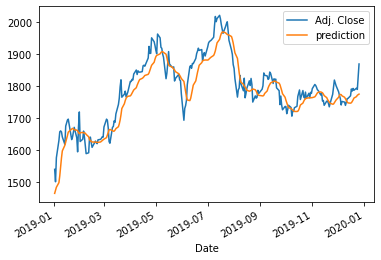

In [ ]:
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)

# **4)RNN(Recurrent Neural Network) Model**

In [ ]:
def simple_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=2)
    my_rnn_model.summary()
    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)
    from sklearn.preprocessing import MinMaxScaler
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions

my_rnn_model, rnn_predictions_2 = simple_rnn_model(X_train, y_train, X_test, sc)

Epoch 1/100
10/10 - 2s - loss: 0.0330 - 2s/epoch - 170ms/step
Epoch 2/100
10/10 - 0s - loss: 0.0092 - 60ms/epoch - 6ms/step
Epoch 3/100
10/10 - 0s - loss: 0.0102 - 60ms/epoch - 6ms/step
Epoch 4/100
10/10 - 0s - loss: 0.0044 - 58ms/epoch - 6ms/step
Epoch 5/100
10/10 - 0s - loss: 0.0075 - 65ms/epoch - 6ms/step
Epoch 6/100
10/10 - 0s - loss: 0.0063 - 63ms/epoch - 6ms/step
Epoch 7/100
10/10 - 0s - loss: 0.0046 - 65ms/epoch - 6ms/step
Epoch 8/100
10/10 - 0s - loss: 0.0057 - 67ms/epoch - 7ms/step
Epoch 9/100
10/10 - 0s - loss: 0.0046 - 71ms/epoch - 7ms/step
Epoch 10/100
10/10 - 0s - loss: 0.0047 - 63ms/epoch - 6ms/step
Epoch 11/100
10/10 - 0s - loss: 0.0030 - 67ms/epoch - 7ms/step
Epoch 12/100
10/10 - 0s - loss: 0.0050 - 63ms/epoch - 6ms/step
Epoch 13/100
10/10 - 0s - loss: 0.0026 - 58ms/epoch - 6ms/step
Epoch 14/100
10/10 - 0s - loss: 0.0032 - 67ms/epoch - 7ms/step
Epoch 15/100
10/10 - 0s - loss: 0.0026 - 64ms/epoch - 6ms/step
Epoch 16/100
10/10 - 0s - loss: 0.0041 - 66ms/epoch - 7ms/step
E

Mean Squared Error: 3118.282000678973
Mean Absolute Error: 50.0857102825364


(3118.2822, <matplotlib.axes._subplots.AxesSubplot at 0x7f54fa17ce50>)

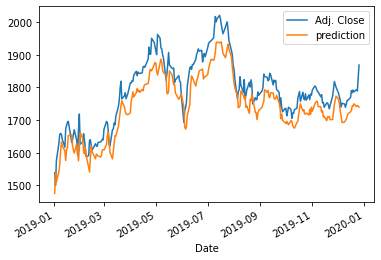

In [ ]:
rnn_predictions_2[1:10]
actual_pred_plot(rnn_predictions_2)